# Content

This notebook processes CSV files summarizing inferred selection coefficients and creates the necessary files to reproduce the figures shown in the article. Additionally, it generates figures corresponding to those in the paper.

In [2]:
#Pkg.add("Pkg"); import Pkg; 
ENV["LD_LIBRARY_PATH"] = ""
using Pkg
using Distributed
using DelimitedFiles
using Distances
using StatsBase  # StatsBase.mode
using CSV
using Profile    
using Random
using Statistics
using LinearAlgebra
using KernelDensity
using Printf
using Measures
using LaTeXStrings;
using Plots
using DataFrames
using StatsPlots
rng = Random.MersenneTwister(1234);

Plots.default(grid =:false, fontfamily="Computer Modern", 
labelfontsize=12, tickfontsize=12, legendfontsize=12, markerstrokewidth=0, ms=5, 
foreground_color_legend = nothing);

In [3]:
include("../src/my_HIV_data_cleanign.jl")
include("../src/figure.jl");

LoadError: SystemError: opening file "/net/dali/home/barton/kais/submission/HIV_Coevolution/src/my_HIV_data_cleanign.jl": No such file or directory

In [4]:
const pxl2pt = 0.75;
α_gen_dbl = 83 * 0.5
α_gen_sgl = 83
α_lbl_dbl = 55.4 * 0.5
α_lbl_sgl = 55.4;
my_margin = 5mm;

In [5]:
Alpha_set_temp = ["-","A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y", "*"];
Alpha_Dic_temp = Dict( "-"=>1,"A"=>2,"C"=>3,"D"=>4,"E"=>5,
	"F"=>6,"G"=>7,"H"=>8,"I"=>9,"K"=>10,"L"=>11,
	"M"=>12,"N"=>13,"P"=>14,"Q"=>15,"R"=>16,"S"=>17,"T"=>18,"V"=>19,"W"=>20, "Y"=>21, "*"=>22);
NUC = ["-", "A", "C", "G", "T"];
q = length(NUC);
AA_set = ["-", "A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y", "*"];
AA2NUM = Dict(AA_set[i] => i for i in 1:length(AA_set));
q_AA = length(AA_set);

In [5]:
fname_key_human_and_RMs = ["703010848", "RM6163", "RM6167", "RM6700", "RM6713", "RM6714", "RM6720"];
n_RMs_max = length(fname_key_human_and_RMs)
n_len_H_RMs = length(fname_key_human_and_RMs);

csv_raw_CH848 = DataFrame(CSV.File("../out/703010848-3-poly_sorted_with_mutant.csv"));
csv_raw_RMs_merged = DataFrame(CSV.File("../out/RMs-merged-3-poly_sorted_with_mutant_CH848.csv"));

seq_raw = readdlm("../data/mpl/703010848-3-poly-seq2state.dat");
time_temp = copy(seq_raw[:,1])
time_unique = Int.(sort(unique(time_temp)));

## Making Trajecotry plots 

In [7]:
L_fig_tot = 1_200
(plot_traject, time_unique, x1_DH270, x1_DH272, x1_DH475, x1_autologous, x1_glycan) = get_trajectory_plot_CH848_with_glycan(
    csv_raw_CH848, L_fig_tot);
(plot_selection_vs_time, time_DH270, time_DH272, time_DH475, time_autologous, time_glycans, 
selection_DH270, selection_DH272, selection_DH475, selection_autologous, selection_glycans, 
mutation_name_DH270, mutation_name_DH272, mutation_name_DH475, mutation_name_strain_specific, mutation_name_glycan) = get_selection_vs_time_plot_CH848_with_glycan(csv_raw_CH848, L_fig_tot);
(plot_violin_plot, s_res_DH270, s_res_DH272, s_res_DH475, s_res_spcfc, s_res_glycan) = get_violin_plot_CH848_with_glycan(csv_raw_CH848, L_fig_tot);


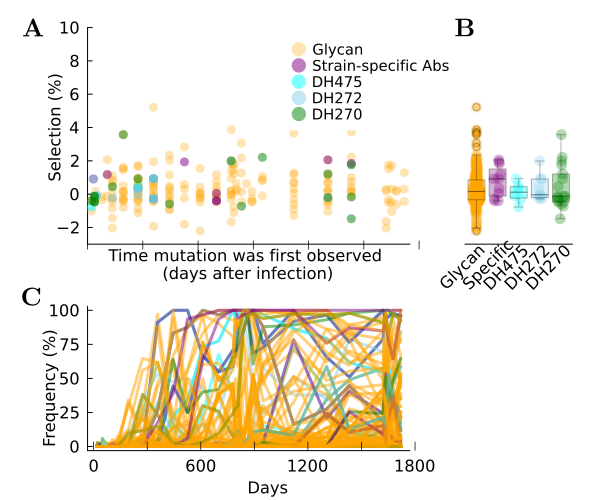

In [8]:
l = @layout [
    a{0.75w, 0.6h} b{0.25w, 0.6h}
    c{0.75w, 0.4h} _]
Plots.plot(plot_selection_vs_time, plot_violin_plot, 
            plot_traject, layout=l, size=(L_fig_tot*0.5,500))
#Plots.savefig("../fig/trajecory_selection_CH848.pdf")

In [9]:
flat_x1_DH270 = [item for sublist in x1_DH270 for item in sublist]
flat_time_DH270 = [item for sublist in x1_DH270 for item in time_unique]
flat_id_DH270 = [@sprintf("DH270.%d", n) for n in 1:size(x1_DH270,1) for i in time_unique]
#
flat_x1_DH272 = [item for sublist in x1_DH272 for item in sublist]
flat_time_DH272 = [item for sublist in x1_DH272 for item in time_unique]
flat_id_DH272 = [@sprintf("DH272.%d", n) for n in 1:size(x1_DH272,1) for i in time_unique]
#
flat_x1_DH475 = [item for sublist in x1_DH475 for item in sublist]
flat_time_DH475 = [item for sublist in x1_DH475 for item in time_unique]
flat_id_DH475 = [@sprintf("DH475.%d", n) for n in 1:size(x1_DH475,1) for i in time_unique]
#
flat_x1_autologous = [item for sublist in x1_autologous for item in sublist]
flat_time_autologous = [item for sublist in x1_autologous for item in time_unique];
flat_id_autologous = [@sprintf("autologous.%d", n) for n in 1:size(x1_autologous,1) for i in time_unique];
#
flat_x1_glycan = [item for sublist in x1_glycan for item in sublist]
flat_time_glycan = [item for sublist in x1_glycan for item in time_unique];
flat_id_glycan = [@sprintf("glycan.%d", n) for n in 1:size(x1_glycan,1) for i in time_unique];

In [32]:
# -------- Export the data for Fig3A, the selection vs time plot -------#
df = DataFrame( 
    id=[flat_id_DH270; flat_id_DH272; flat_id_DH475; flat_id_autologous; flat_id_glycan], 
    time=[flat_time_DH270; flat_time_DH272; flat_time_DH475; flat_time_autologous; flat_time_glycan], 
    frequency=[flat_x1_DH270; flat_x1_DH272; flat_x1_DH475; flat_x1_autologous; flat_x1_glycan], 
);
CSV.write("../out/for_figures/figS4C_trajectory.csv", df); 

In [ ]:
df = DataFrame(
    category=[repeat(["DH270"], length(time_DH270)); repeat(["DH272"], length(time_DH272));
     repeat(["DH475"], length(time_DH475)); repeat(["autologous"], length(time_autologous)); repeat(["glycan"], length(time_glycans))], 
    mutation=[mutation_name_DH270; mutation_name_DH272; mutation_name_DH475; mutation_name_strain_specific; mutation_name_glycan],
    time=[time_DH270; time_DH272; time_DH475; time_autologous; time_glycans], 
    selection=[selection_DH270; selection_DH272; selection_DH475; selection_autologous; selection_glycans] );
#CSV.write("../out/for_figures/figS4A_selection_vs_time.csv", df); 

In [11]:
idx_glycan = df[:, 1] .== "glycan"; 
idx_in_460_to_466 = Bool.([x ∈ 460:466 for x in extract_integer.(df.mutation)]);

13

## Selection, detected time, frequency trajectory for reduced data. 

In [12]:
L_fig_tot = 1200
(plot_trajectory, time_unique, x1_set_for_figures_nef, x1_set_for_figures_env, x1_set_for_figures_else) = get_trajectory_plot_CH848_reduced(csv_raw_CH848, L_fig_tot) 

(plot_s_vs_t, time_nef_figure, time_env_figure, time_els_figure, 
        selection_nef_figure, selection_env_figure, selection_els_figure) = get_selection_vs_time_plot_CH848_reduced(csv_raw_CH848, L_fig_tot)
(plot_s_violin, s_res_nef, s_res_env, s_res_els) = get_violin_plot_CH848_reduced(csv_raw_CH848, L_fig_tot);

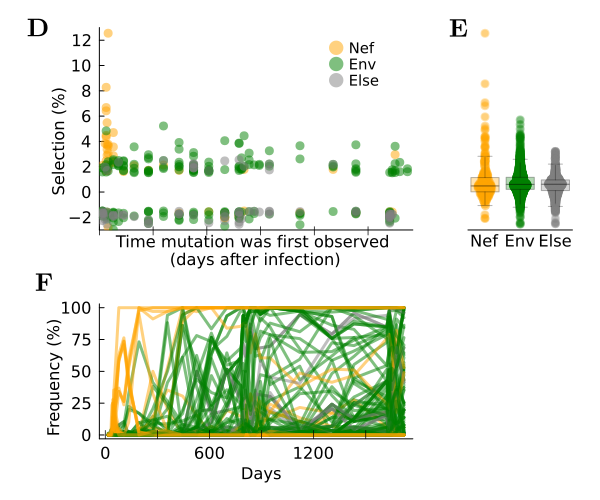

In [13]:
l = @layout [
    plot_s_vs_t{0.75w, 0.6h} plot_s_violin{0.25w, 0.6h}
    plot_trajectory{0.75w, 0.4h} _ ]
Plots.plot(plot_s_vs_t, plot_s_violin, plot_trajectory, layout=l, size=(L_fig_tot*0.5,500))
#Plots.savefig("../fig/CH848/trajecory_sselection_CH848.pdf")

In [14]:
flat_x1_nef = [item for sublist in x1_set_for_figures_nef for item in sublist]
flat_time_nef = [item for sublist in x1_set_for_figures_nef for item in time_unique]
flat_id_nef = [@sprintf("nef.%d", n) for n in 1:size(x1_set_for_figures_nef,1) for i in time_unique]
#
flat_x1_env = [item for sublist in x1_set_for_figures_env for item in sublist]
flat_time_env = [item for sublist in x1_set_for_figures_env for item in time_unique]
flat_id_env = [@sprintf("env.%d", n) for n in 1:size(x1_set_for_figures_env,1) for i in time_unique]
#
flat_x1_els = [item for sublist in x1_set_for_figures_else for item in sublist]
flat_time_els = [item for sublist in x1_set_for_figures_else for item in time_unique]
flat_id_els = [@sprintf("els.%d", n) for n in 1:size(x1_set_for_figures_else,1) for i in time_unique];


In [139]:
# -------- Export the data for Fig3A, the selection vs time plot -------#
df = DataFrame( 
    id=[flat_id_nef; flat_id_env; flat_id_els], 
    time=[flat_time_nef; flat_time_env; flat_time_els], 
    frequency=[flat_x1_nef; flat_x1_env; flat_x1_els], 
)
CSV.write("../out/for_figures/fig3F_trajectory.csv", df); 

In [140]:
df = DataFrame(
    category=[repeat(["nef"], length(time_nef_figure)); repeat(["env"], length(time_env_figure));
        repeat(["else"], length(time_els_figure))], 
    time=[time_nef_figure; time_env_figure; time_els_figure], 
   selection=[selection_nef_figure; selection_env_figure; selection_els_figure] 
)
CSV.write("../out/for_figures/fig3D_selection_vs_time.csv", df); 

## Compare Fitness landscape of RMs and CH848

In [26]:
csv_raw_CH848 = DataFrame(CSV.File("../data/mpl/SHIV.CH848_AA/703010848-poly.csv"));
poly_idx_CH848 =  DataFrame(CSV.File("../data/mpl/SHIV.CH848_AA/index-703010848.csv"));
poly_idx_RMs = DataFrame(CSV.File("../data/mpl/SHIV.CH848_AA/index-RMs-poly.csv"));
csv_raw_RMs_merged = DataFrame(CSV.File("../data/mpl/SHIV.CH848_AA/RMs-poly.csv"));
n_H_RMs = length(fname_key_human_and_RMs);
fname_dev = ["RM6163", "RM6167"]
marker_set_with_human = ["circle", "circle", "circle", "utriangle", "utriangle", "utriangle", "utriangle"];


## Compare fitness landscapes of CH848 and jointed SHIV.CH848

In [16]:
dir_name = "../data/mpl/SHIV.CH848_AA/"
(fitness_ind_tot_CH848_random_set, fitness_ind_tot_RMs_random_set, 
 mean_fitness_ind_tot_CH848_random_set, mean_fitness_ind_tot_RMs_random_set,     
 errorbar_tot_CH848_set, errorbar_tot_RMs_set, 
    date_unique_set, bool_BNB_nonBNB) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH848, csv_raw_RMs_merged; flag_include_HIV = false, flag_shuffle = false);

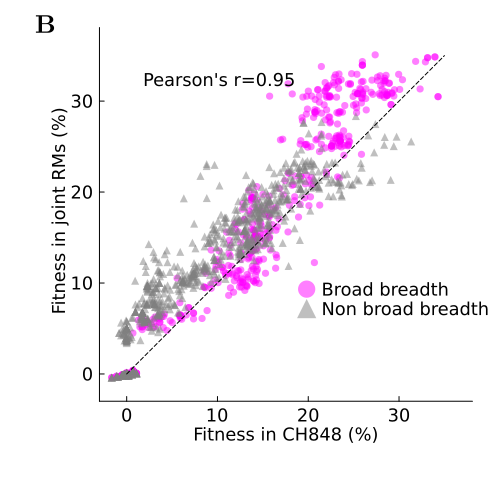

In [17]:
L_fig = 500
fontsize_reg = Int(ceil((2*L_fig)/α_gen_sgl * pxl2pt * (1.0/0.8))) # because we rescale these figures
fontsize_label_reg = Int(ceil((2*L_fig)/α_lbl_sgl * pxl2pt* (1.0/0.8)))
my_alpha = 0.5

fitness_ind_tot_CH848_random_set_vec = copy(reduce(vcat, fitness_ind_tot_CH848_random_set))
fitness_ind_tot_RMs_random_set_vec = copy(reduce(vcat, fitness_ind_tot_RMs_random_set))

max_x = maximum([maximum(fitness_ind_tot_CH848_random_set_vec), maximum(fitness_ind_tot_RMs_random_set_vec)]) + 3
p1tot = scatter(fitness_ind_tot_CH848_random_set_vec[Bool.(bool_BNB_nonBNB)], 
            fitness_ind_tot_RMs_random_set_vec[Bool.(bool_BNB_nonBNB)],
            label="Broad breadth", 
            c=:magenta, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            grid=:false,
            m = :circle,
            margin=my_margin, 
            xlabel="Fitness in CH848 (%)\n ", 
            ylabel=" \n Fitness in joint RMs (%)",
            legend=(0.6, 0.3),
            legendfontsize=fontsize_reg, 
            tickfontsize=fontsize_reg,
)
scatter!(fitness_ind_tot_CH848_random_set_vec[.!Bool.(bool_BNB_nonBNB)], 
            fitness_ind_tot_RMs_random_set_vec[.!Bool.(bool_BNB_nonBNB)],
            label="Non broad breadth", 
            c=:gray, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            legend=(0.6, 0.3),
            m =:utriangle,
)
pearson_cor = cor(fitness_ind_tot_CH848_random_set_vec, fitness_ind_tot_RMs_random_set_vec);
annotate!(2, max_x*0.85, text(@sprintf("Pearson's r=%.2f", pearson_cor), 
        fontsize_reg, :left, rotation=0, color=:black))
Plots.plot!(p1tot[1], collect(0:35), collect(0:35), sybplot=1, c="black", linestyle=:dash, label=:false)
annotate!(-10, max_x*1.01, text(L"\textbf{B}", :left, fontsize_label_reg))

Plots.plot(p1tot, size=(L_fig, L_fig))


In [144]:
# -------- Export the data for Fig4A, comparison of CH848 and jointed RMs fitness landscapes  -------#
df = DataFrame( F_CH848 = fitness_ind_tot_CH848_random_set_vec,
                F_jointedRMs = fitness_ind_tot_RMs_random_set_vec,
                breadth = bool_BNB_nonBNB );
#CSV.write("../out/for_figures/fig4B_fitness_comparison.csv", df); 

### Shuffled sequences 

In [18]:
dir_name = "../data/mpl/SHIV.CH848_AA/"
(fitness_ind_tot_CH848_shuffle_set, fitness_ind_tot_RMs_shuffle_set, 
 mean_fitness_ind_tot_CH848_shuffle_set, mean_fitness_ind_tot_RMs_shuffle_set,     
 errorbar_tot_CH848_shuffle_set, errorbar_tot_RMs_shuffle_set, 
    date_unique_set_shuffle, bool_BNB_nonBNB_shuffle) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH848, csv_raw_RMs_merged; flag_include_HIV = false, flag_shuffle = true);

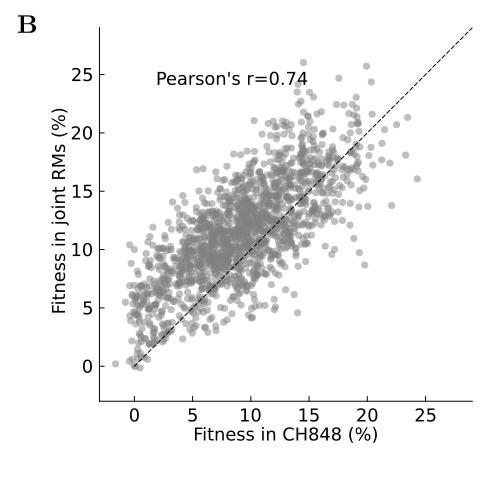

In [19]:
L_fig = 500
fontsize_reg = Int(ceil((2*L_fig)/α_gen_sgl * pxl2pt * (1.0/0.8))) # because we rescale these figures
fontsize_label_reg = Int(ceil((2*L_fig)/α_lbl_sgl * pxl2pt* (1.0/0.8)))
my_alpha = 0.5

fitness_ind_tot_CH848_shuffle_set_vec = copy(reduce(vcat, fitness_ind_tot_CH848_shuffle_set))
fitness_ind_tot_RMs_shuffle_set_vec = copy(reduce(vcat, fitness_ind_tot_RMs_shuffle_set))

max_x = maximum([maximum(fitness_ind_tot_CH848_shuffle_set_vec), maximum(fitness_ind_tot_RMs_shuffle_set_vec)]) + 3
p1tot = scatter(fitness_ind_tot_CH848_shuffle_set_vec[Bool.(bool_BNB_nonBNB_shuffle)], 
            fitness_ind_tot_RMs_shuffle_set_vec[Bool.(bool_BNB_nonBNB_shuffle)],
            legend=:false,
            c=:gray, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            grid=:false,
            m = :circle,
            margin=my_margin, 
            xlabel="Fitness in CH848 (%)\n ", 
            ylabel=" \n Fitness in joint RMs (%)",
            legendfontsize=fontsize_reg, 
            tickfontsize=fontsize_reg,
)
scatter!(fitness_ind_tot_CH848_shuffle_set_vec[.!Bool.(bool_BNB_nonBNB_shuffle)], 
            fitness_ind_tot_RMs_shuffle_set_vec[.!Bool.(bool_BNB_nonBNB_shuffle)],
            legend=:false,
            c=:gray, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            m =:circle,
)
pearson_cor = cor(fitness_ind_tot_CH848_shuffle_set_vec, fitness_ind_tot_RMs_shuffle_set_vec);
annotate!(2, max_x*0.85, text(@sprintf("Pearson's r=%.2f", pearson_cor), 
        fontsize_reg, :left, rotation=0, color=:black))
Plots.plot!(p1tot[1], collect(0:35), collect(0:35), sybplot=1, c="black", linestyle=:dash, label=:false)
annotate!(-10, max_x*1.01, text(L"\textbf{B}", :left, fontsize_label_reg))

Plots.plot(p1tot, size=(L_fig, L_fig))


In [147]:
# -------- Export the data for Fig4A, comparison of CH848 and jointed RMs fitness landscapes  -------#
df = DataFrame( F_CH848 = fitness_ind_tot_CH848_shuffle_set_vec,
                F_jointedRMs = fitness_ind_tot_RMs_shuffle_set_vec,
                breadth = bool_BNB_nonBNB_shuffle )
CSV.write("../out/for_figures/figS3B_fitness_comparison_using_shuffled_seq.csv", df); 

## Fitness change Plots 

α_dev=0.062 α_undev=0.062 


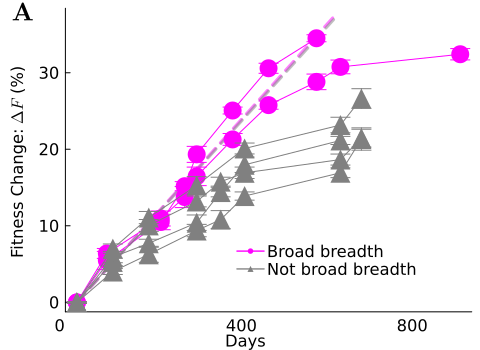

In [148]:
# This figure would be double column
n_H_RMs = length(fname_key_human_and_RMs)
k = 1
L_fig_tot = 1200
L_fig = Int(0.4*L_fig_tot)
fontsize_reg = Int(ceil(L_fig_tot/α_gen_sgl * pxl2pt))
fontsize_label_reg = Int(ceil(L_fig_tot/α_lbl_sgl * pxl2pt))

my_ms = 10
α_lin_dev = linreg(date_unique_set[k][1:7], mean_fitness_ind_tot_RMs_random_set[k][1:7])
α_lin_dev += linreg(date_unique_set[k+1][1:7], mean_fitness_ind_tot_RMs_random_set[k+1][1:7])
α_lin_undev = linreg(date_unique_set[3][1:4], mean_fitness_ind_tot_RMs_random_set[3][1:4])
for k_temp in 3:6 α_lin_undev += linreg(date_unique_set[k_temp][1:4], mean_fitness_ind_tot_RMs_random_set[k_temp][1:4]) end
α_lin_dev /= 2; α_lin_undev /= 4
@printf("α_dev=%.3f α_undev=%.3f \n", α_lin_dev, α_lin_undev)

p = Plots.plot(collect(0:100:600), α_lin_dev*collect(0:100:600), linestyle=:dash, c=:magenta, label=:false, lw=3, alpha=0.5)
Plots.plot!(collect(0:100:600), α_lin_undev*collect(0:100:600), linestyle=:dash, c=:gray, label=:false, lw=3, alpha=0.5)


plot!(date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], 
#    m=Symbol(marker_set_with_human[k]), label=fname_key_human_and_RMs[k],     
    m=Symbol(marker_set_with_human[k+1]), label="Broad breadth",
    yerror=errorbar_tot_RMs_set[k],
    markerstrokecolor="magenta",
    c="magenta",
    size=(L_fig,Int(350)),
    foreground_color_legend = nothing,
    labelfontsize=fontsize_reg,
    grid=:false,
    margin=0.1mm, 
    ms=my_ms,
    xlabel=" \n ", 
    ylabel=" \n ", 
    xticks=:false,
#    xlim=(-10, 900),
    legend=(0.5, 0.2),
#    legend=:false,
    legendfontsize=fontsize_reg, 
    tickfontsize=fontsize_reg,
)
annotate!(-140, 6, text(L"Fitness Change: $ΔF$ (%)", fontsize_reg, :left, rotation=90))
annotate!(350, -5, text("Days", fontsize_reg, :left))
[annotate!(i-50, -3, text(string(i), fontsize_reg, :left)) for i in [0, 400, 800]]

for k in 2:(n_H_RMs-1)
    key_RM = fname_key_human_and_RMs[k+1]
    this_c = "gray"
    if(key_RM ∈ fname_dev) this_c = "magenta" end
#    if(key_RM == "RM6072") this_c = "pink" end
    if(k==4)
        plot!(p[1], date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], ms=my_ms,
            yerror=errorbar_tot_RMs_set[k], markerstrokecolor=this_c,
            sbuplot=1, m=Symbol(marker_set_with_human[k+1]), label="Not broad breadth", c=this_c)
    end
    if(k!=4)
        plot!(p[1], date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], ms=my_ms,
            yerror=errorbar_tot_RMs_set[k], markerstrokecolor=this_c,
            sbuplot=1, m=Symbol(marker_set_with_human[k+1]), label=:false, c=this_c)
    end
end
#display(p);
annotate!(-150, 38, text(L"\textbf{A}", :left, fontsize_label_reg))
#Plots.savefig("../fig/CH848/fitness_change_mutations_left_fig.pdf")

In [41]:
dir_name = "../data/mpl/SHIV.CH848_AA/"

##Note this function exclude HIV because the flag_include_HIV is off.
(fitness_ind_tot_CH848_random_set, fitness_ind_tot_RMs_random_set, 
 mean_fitness_ind_tot_CH848_random_set, mean_fitness_ind_tot_RMs_random_set,     
 errorbar_tot_CH848_set, errorbar_tot_RMs_set, 
    date_unique_set, bool_BNB_nonBNB) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH848, csv_raw_RMs_merged; flag_include_HIV = false, flag_shuffle = false);

#RM_id = [@sprintf("RM%d", k) for k in 1:size(date_unique_set,1) for _ in date_unique_set[k]]
RM_id = [fname_key_human_and_RMs[k+1] for k in 1:size(date_unique_set,1) for _ in date_unique_set[k]]
# Suppose RMs 1-3 have broad breadth 
breadth = [x ∈ fname_key_human_and_RMs[1:3]  for x in RM_id ]
date = [item for sublist in date_unique_set for item in sublist]
mean_F = [item for sublist in mean_fitness_ind_tot_RMs_random_set for item in sublist]
std_F = [item for sublist in errorbar_tot_RMs_set for item in sublist];
#CSV.write("../out/for_figures/figS6A_fitness_change.csv", df);
#"""
dir_name = "../data/mpl/SHIV.CH848_AA/"
(fitness_ind_tot_CH848_random_set, fitness_ind_tot_RMs_random_set, 
 mean_fitness_ind_tot_CH848_random_set, mean_fitness_ind_tot_RMs_random_set,     
 errorbar_tot_CH848_set, errorbar_tot_RMs_set, 
    date_unique_set, bool_BNB_nonBNB) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH848, csv_raw_RMs_merged; flag_include_HIV = true, flag_shuffle = false);

RM_id = [copy(RM_id); ["CH848" for _ in date_unique_set[1]]]    
breadth = [copy(breadth); [true for _ in date_unique_set[1]]]
date = [copy(date); date_unique_set[1]]
mean_F = [copy(mean_F); mean_fitness_ind_tot_CH848_random_set[1]]
std_F = [copy(std_F); errorbar_tot_CH848_set[1]];
#"""


df = DataFrame(
    RM_id = RM_id,
    breadth = breadth,
    date = date,
    mean_F = mean_F,
    std_F = std_F
)   ;


In [42]:
CSV.write("../out/for_figures/figS6A_fitness_change.csv", df);

### Including HIV sequences for projection onto the jont RMs fitness landscape.

## Characterize RMs developed bnAbs and ddn't develop bnAbs  

In [46]:
dir_name = "../data/mpl/SHIV.CH848_AA/"
L_fig_tot = 1200# 3600
(plot_selected_heatmap, heatmap_BNB_or_nonBNB, mutation_names_BNB_or_nonBNB, heatmap_only_BNB, mutation_names_only_BNB) = get_heatmap_selected_mutations_CH848(dir_name, L_fig_tot);


In [48]:
flat_mat_value = []
category_name = []
model_name = []
mutation_name = []
location_name = []
#model_name_list = reverse(["jointed_RMs"; [@sprintf("RM%d", i) for i in 1:7]])
model_name_list = reverse(["jointed_RMs"; [fname_key_human_and_RMs[i] for i in 2:7]])
for i in 1:size(heatmap_BNB_or_nonBNB, 1)
    for j in 1:size(heatmap_BNB_or_nonBNB, 2)
        push!(model_name, model_name_list[i])
        mut_name_temp = mutation_names_BNB_or_nonBNB[j]
        push!(mutation_name, mut_name_temp)
        push!(category_name, "BNB_or_nonBNB")
        if(isnothing(get_variable_regions(extract_integer(mut_name_temp))))
            push!(location_name, "NaN")
        else
            push!(location_name, get_variable_regions(extract_integer(mut_name_temp)))
        end
            
        if(heatmap_BNB_or_nonBNB[i,j]>-0.09)
            push!(flat_mat_value, heatmap_BNB_or_nonBNB[i,j])
        else
            push!(flat_mat_value, "NaN")
        end
    end
end
for i in 1:size(heatmap_only_BNB, 1)
    for j in 1:size(heatmap_only_BNB, 2)
        push!(model_name, model_name_list[i])
        mut_name_temp = mutation_names_only_BNB[j]
        push!(mutation_name, mut_name_temp)
        push!(category_name, "only_BNB")
        if(isnothing(get_variable_regions(extract_integer(mut_name_temp))))
            push!(location_name, "NaN")
        else
            push!(location_name, get_variable_regions(extract_integer(mut_name_temp)))
        end
        if(heatmap_only_BNB[i,j]>-0.09)
            push!(flat_mat_value, heatmap_only_BNB[i,j])
        else
            push!(flat_mat_value, "NaN")
        end
    end
end
        

In [49]:
df = DataFrame(
    category = category_name, 
    model = model_name,
    mutation = mutation_name,
    location = location_name,
    selection = flat_mat_value
);
CSV.write("../out/for_figures/fig6SB_selected_mutations.csv", df);

## Compare correlation of fitness landscapes among the all subjects

In [69]:
# ------------ Get heatmap of the Pearson's r matrix ------------#
L_fig = 500
n_rand_max=10
dir_name = "../data/mpl/SHIV.CH848_AA/"
fname_key_in = "703010848"
title_fig = "SHIV.CH848"
#fname_key_human_and_RMs
shuffle_flag = false

(p_out, p_out_v2, cor_mat_smry, cor_mat_smry_std, spearman_mat_smry, 
    spearman_mat_smry_std, slope_mat_smry, slope_mat_smry_std) = get_correlation_sumamry(fname_key_human_and_RMs, dir_name, 
    title_fig, fname_key_in, L_fig, n_rand_max, shuffle_flag);


In [6]:

#Plots.savefig("../fig/Fitness_similarity_all_to_all_CH848_without_shuffle.png")
#Plots.plot(p_out, size=(600, 600) )
#Plots.plot(p_out_v2, size=(600, 600) )

In [ ]:
cor_mean_set = []; cor_std_set = []
model1_set = []; model2_set = []
model_name_list = [["CH848", "jointed_RMs"]; [@sprintf("RM%d", i) for i in 1:6]]
for i in 1:size(cor_mat_smry,1)
    for j in (i+1):size(cor_mat_smry,2)
        push!(cor_mean_set, cor_mat_smry[i,j])
        push!(cor_std_set, cor_mat_smry_std[i,j])
        push!(model1_set, model_name_list[i])
        push!(model2_set, model_name_list[j])
    end
end;

# ------- Export the data for Fig.S5A, Pearson's r matrix   -------#
df = DataFrame(
    model1=model1_set, 
    model2=model2_set, 
    r_mean=cor_mean_set, 
    r_std=cor_std_set
);
#CSV.write("../out/for_figures/figS5B_pearson_mat.csv", df); 

## Comapre time when detected and selection coefficinet

In [159]:
# -------- Make Selection vs time plot for SHIV dsata ---------#
dir_name= "../data/mpl/SHIV.CH848_AA/"
L_fig_tot = 1200

(p1, p_violin, s_BNB_set, date_BNB_set, s_notBNB_set, 
    date_notBNB_set, date_bnAbs_RMs, s_bnAbs_RMs) = get_selection_vs_time_SHIV848(dir_name, L_fig_tot);


In [160]:
df = DataFrame(
    model = [repeat(["BNB"], length([date_BNB_set; date_bnAbs_RMs])); 
            repeat(["nonBNB"], length(date_notBNB_set))],
    date = [date_BNB_set; date_bnAbs_RMs; date_notBNB_set],
    selection = [s_BNB_set; s_bnAbs_RMs; s_notBNB_set],
    bnAbs = [[false for _ in 1:length(s_BNB_set)]; 
     [true for _ in 1:length(s_bnAbs_RMs)];
     [false for _ in 1:length(s_notBNB_set)]])
CSV.write("../out/for_figures/fig5CD_selection_vs_time_SHIV.csv", df); 

### The following cells obtain trajectories and mutations that involved in glycan and/or resistant to bnAbs. 

In [66]:
# At the directory for the /data/mpl/SHIV.CH505_AA/ there are fies named RM<id>-poly.csv with names of mutaions. 
# Given TF's amino acid sequences, we should be able to identify the mutations that alter the glycan and its trajectories. 

TF_seq_aa_raw = DataFrame(CSV.File("../data/mpl/SHIV.CH848_AA/index-703010848.csv"));
TF_aa = String.(TF_seq_aa_raw.TF)
TF_seq = TF_aa
TF_HXB2 = String.(TF_seq_aa_raw.HXB2);
len_seq = length(TF_HXB2);

In [67]:
individual_set = []
id_set_csv = []; types_set_csv = []
date_set_csv = []; mutation_name_set_csv = [];  freq_set_csv = []
#
date_mutation_was_detected_s_vs_t = []
id_set_s_vs_t = []; types_set_s_vs_t = []; individual_set_s_vs_t = []; selection_RMs_set_s_vs_t = []
mutations_set_s_vs_t = []; selection_set_s_vs_t = []
mutation_resistant_bnAbs = ["N301D", "D325N", "V295N", "D325N"];
VL_enhancing = ["N130D", "N279D", "K302N", "Y330H", "N334S", "H417R"]
fname_Human_RM = ["703010848", "RM6163", "RM6167", "RM6700", "RM6713", "RM6714", "RM6720"];

csv_raw_RMs = DataFrame(CSV.File("../data/mpl/SHIV.CH848_AA/RMs-poly.csv"));
for i_HRM in 2:length(fname_Human_RM)
    csv_raw_in = DataFrame(CSV.File(@sprintf("../data/mpl/SHIV.CH848_AA/%s-poly.csv", fname_Human_RM[i_HRM])));
    (extracted_integers, index_to_find_integers) = get_date_of_freq(csv_raw_in)
    n_mutation_selected = 0
    for n in 1:length(csv_raw_in.mutation)
        x = csv_raw_in.mutation[n]
        x_splited = split(x, "")
        date_detected = 1
        if(fname_Human_RM[i_HRM] != "RMs")
            date_detected = csv_raw_in.date[n]
        end
        
        mut_wt = x_splited[1]; mut_mt = x_splited[end]
        i_hxb2 = join(x_splited[2:(end-1)])
        #@printf("%s, %s, %s\n", i_hxb2, mut_wt, mut_mt)
        if( i_hxb2 ∈ TF_HXB2 && (date_detected > 0))
            i_seq = collect(1:len_seq)[TF_HXB2 .== i_hxb2][1]        
            n_mutation_selected += 1
            TF_AA = String(TF_seq[i_seq])
            mut_AA = String(mut_mt)
            (n_glycan_plus, n_glycan_minus) = get_glycosylation_simple_AA(i_seq, mut_AA, TF_seq, len_seq)
            #@printf("%d %d\n", n_glycan_plus, n_glycan_minus)
            
            if(n_glycan_plus>0 || n_glycan_minus>0)
                mutation_id = join([fname_Human_RM[i_HRM], n_mutation_selected], ".")
                #types_of_mutation = "glycan" 
                types_of_mutation = "glycan_shield"
                if(n_glycan_minus>0)
                    types_of_mutation = "glycan_holes"
                end
                if(n_glycan_minus>0 && n_glycan_plus>0)
                    types_of_mutation = "glycan_shift"
                end
                push!(individual_set_s_vs_t, fname_Human_RM[i_HRM])
                push!(date_mutation_was_detected_s_vs_t, date_detected)
                push!(id_set_s_vs_t, mutation_id)
                push!(types_set_s_vs_t, types_of_mutation)
                push!(mutations_set_s_vs_t, csv_raw_in.mutation[n])
                push!(selection_set_s_vs_t, csv_raw_in.s_MPL[n])
                id_find_mutations = csv_raw_RMs.mutation .== csv_raw_in.mutation[n]
                if(count(id_find_mutations)>0)
                    push!(selection_RMs_set_s_vs_t, csv_raw_RMs.s_MPL[id_find_mutations][1])
                else
                    push!(selection_RMs_set_s_vs_t, 0.0)
                end
                #
                for (date_this, index_this) in zip(extracted_integers, index_to_find_integers)
                    push!(individual_set, fname_Human_RM[i_HRM])
                    date_this_mutation = date_this # this information is used for making trajectory plots.
                    freq_this = csv_raw_in[n, index_this]
                    push!(id_set_csv, mutation_id)
                    push!(types_set_csv, types_of_mutation)
                    push!(date_set_csv, date_this_mutation)
                    push!(mutation_name_set_csv, csv_raw_in.mutation[n])
                    push!(freq_set_csv, freq_this)
                end
            end
        end
        #
        if(x ∈ mutation_resistant_bnAbs && (date_detected > 0))
            n_mutation_selected += 1
            mutation_id = join([fname_Human_RM[i_HRM], n_mutation_selected], ".")
            types_of_mutation = "bnAbs_resistance" 
            push!(individual_set_s_vs_t, fname_Human_RM[i_HRM])
            push!(date_mutation_was_detected_s_vs_t, date_detected)
            push!(id_set_s_vs_t, mutation_id)
            push!(types_set_s_vs_t, types_of_mutation)
            push!(mutations_set_s_vs_t, csv_raw_in.mutation[n])
            push!(selection_set_s_vs_t, csv_raw_in.s_MPL[n])
            id_find_mutations = csv_raw_RMs.mutation .== csv_raw_in.mutation[n]
            if(count(id_find_mutations)>0)
                push!(selection_RMs_set_s_vs_t, csv_raw_RMs.s_MPL[id_find_mutations][1])
            else
                push!(selection_RMs_set_s_vs_t, 0.0)
            end
            for (date_this, index_this) in zip(extracted_integers, index_to_find_integers)
                push!(individual_set, fname_Human_RM[i_HRM])
                date_this_mutation = date_this # this information is used for making trajectory plots.
                freq_this = csv_raw_in[n, index_this]
                push!(id_set_csv, mutation_id)
                push!(types_set_csv, types_of_mutation)
                push!(date_set_csv, date_this_mutation)
                push!(mutation_name_set_csv, csv_raw_in.mutation[n])
                push!(freq_set_csv, freq_this)
            end
        end
        if(x ∈ VL_enhancing && (date_detected > 0))
            n_mutation_selected += 1
            mutation_id = join([fname_Human_RM[i_HRM], n_mutation_selected], ".")
            types_of_mutation = "increase_VL" 
            push!(individual_set_s_vs_t, fname_Human_RM[i_HRM])
            push!(date_mutation_was_detected_s_vs_t, date_detected)
            push!(id_set_s_vs_t, mutation_id)
            push!(types_set_s_vs_t, types_of_mutation)
            push!(mutations_set_s_vs_t, csv_raw_in.mutation[n])
            push!(selection_set_s_vs_t, csv_raw_in.s_MPL[n])
            id_find_mutations = csv_raw_RMs.mutation .== csv_raw_in.mutation[n]
            if(count(id_find_mutations)>0)
                push!(selection_RMs_set_s_vs_t, csv_raw_RMs.s_MPL[id_find_mutations][1])
            else
                push!(selection_RMs_set_s_vs_t, 0.0)
            end
            push!(selection_RMs_set_s_vs_t, )
            for (date_this, index_this) in zip(extracted_integers, index_to_find_integers)
                push!(individual_set, fname_Human_RM[i_HRM])
                date_this_mutation = date_this # this information is used for making trajectory plots.
                freq_this = csv_raw_in[n, index_this]
                push!(id_set_csv, mutation_id)
                push!(types_set_csv, types_of_mutation)
                push!(date_set_csv, date_this_mutation)
                push!(mutation_name_set_csv, csv_raw_in.mutation[n])
                push!(freq_set_csv, freq_this)
            end
        end
    end
end


In [68]:
df = DataFrame(
    individual = individual_set, 
    id = id_set_csv,
    types = types_set_csv,
    date = date_set_csv,
    mutation = mutation_name_set_csv,
    frequency = freq_set_csv
);
CSV.write("../out/for_figures/trajectories_RMs_SHIVCH848.csv", df);
#
df = DataFrame(
    individual = individual_set_s_vs_t, 
    id = id_set_s_vs_t,
    types = types_set_s_vs_t,
    date = date_mutation_was_detected_s_vs_t,
    mutation = mutations_set_s_vs_t,
    selection = selection_set_s_vs_t, 
    selection_RMs = selection_RMs_set_s_vs_t
);
CSV.write("../out/for_figures/selection_RMs_SHIVCH848.csv", df);

## check the number of the common mutations acorss macques. 

In [54]:
csv_raw_RMs = DataFrame(CSV.File("../data/mpl/SHIV.CH848_AA/RMs-poly.csv"));
idx_to_look = extract_integer.(csv_raw_RMs.mutation) .!= 375
csv_raw_RMs = copy(csv_raw_RMs[idx_to_look, :])
selection_vector_set_all = []
for i_HRM in 2:length(fname_Human_RM)
    csv_raw_in = DataFrame(CSV.File(@sprintf("../data/mpl/SHIV.CH848_AA/%s-poly.csv", fname_Human_RM[i_HRM])));
    selection_vector_RM = []
    for n in 1:length(csv_raw_RMs.HXB2)
        mut_in = csv_raw_RMs.mutation[n]
        idx_detected = csv_raw_in.mutation .== mut_in
        if((count(idx_detected) > 0))
            s_in_str = @sprintf("%.6f", csv_raw_in.s_MPL[idx_detected][1])
            push!(selection_vector_RM, s_in_str)
        else
            push!(selection_vector_RM, "NaN")
        end;
    end
    push!(selection_vector_set_all, copy(selection_vector_RM) )
end;

# making csv files having selection coefficients estimated by individual, if there is no mutations then put NaN 


In [55]:
df = DataFrame(
    HXB2=csv_raw_RMs.HXB2,
    PRO=csv_raw_RMs.PRO,
    TF=csv_raw_RMs.TF,
    mutation=csv_raw_RMs.mutation,
    RMs=csv_raw_RMs.s_MPL,
    RM6163=selection_vector_set_all[1],
    RM6167=selection_vector_set_all[2],
    RM6700=selection_vector_set_all[3],
    RM6713=selection_vector_set_all[4],
    RM6714=selection_vector_set_all[5],
    RM6720=selection_vector_set_all[6]
    ); 
CSV.write("../out/for_figures/selection_RMs_summarizing_all_SHIVCH848.csv", df);

In [63]:
csv_summary = DataFrame(CSV.File("../out/for_figures/selection_RMs_summarizing_all_SHIVCH848.csv"));
n_macaques_threshold = 3;
idx_common_mutations = []
mean_s_set = []
for n in 1:length(csv_raw_RMs.HXB2)
    not_NaN = string.(collect(csv_summary[n, 6:end])) .!="NaN"
    if(count(not_NaN) > n_macaques_threshold)
        push!(idx_common_mutations, true)
        mean_s = mean(csv_summary[n, 5 .+ collect(1:6)[not_NaN] ])
        push!(mean_s_set, mean_s)
    else
        push!(idx_common_mutations, false)
        push!(mean_s_set, "NaN")
    end
        
end
idx_common_mutations = Bool.(idx_common_mutations);

In [64]:
df = DataFrame(
    HXB2=csv_raw_RMs.HXB2[idx_common_mutations],
    PRO=csv_raw_RMs.PRO[idx_common_mutations],
    TF=csv_raw_RMs.TF[idx_common_mutations],
    mutation=csv_raw_RMs.mutation[idx_common_mutations],
    RMs=csv_raw_RMs.s_MPL[idx_common_mutations],
    RM6163=selection_vector_set_all[1][idx_common_mutations],
    RM6167=selection_vector_set_all[2][idx_common_mutations],
    RM6700=selection_vector_set_all[3][idx_common_mutations],
    RM6713=selection_vector_set_all[4][idx_common_mutations],
    RM6714=selection_vector_set_all[5][idx_common_mutations],
    RM6720=selection_vector_set_all[6][idx_common_mutations],
    mean_S=mean_s_set[idx_common_mutations]
    ); 
CSV.write("../out/for_figures/selection_RMs_common_mutations_SHIVCH848.csv", df);

In [65]:
csv_in = DataFrame(CSV.File("../out/for_figures/selection_RMs_common_mutations_SHIVCH848.csv"));
idx_sorted = sortperm(csv_in.mean_S, rev=true)
df = DataFrame(
    HXB2=csv_in.HXB2[idx_sorted],
    PRO=csv_in.PRO[idx_sorted],
    TF=csv_in.TF[idx_sorted],
    mutation=csv_in.mutation[idx_sorted],
    RMs=csv_in.RMs[idx_sorted],
    RM6163=csv_in.RM6163[idx_sorted],
    RM6167=csv_in.RM6167[idx_sorted],
    RM6700=csv_in.RM6700[idx_sorted],
    RM6713=csv_in.RM6713[idx_sorted],
    RM6714=csv_in.RM6714[idx_sorted],
    RM6720=csv_in.RM6720[idx_sorted], 
    mean_S=csv_in.mean_S[idx_sorted]
    ); 
CSV.write("../out/for_figures/selection_RMs_common_mutations_SHIVCH848_sorted.csv", df);